# Experiments for NIPS 2016
---

* ~~Inspect JA, EE trajectories for Clothing Assistance Tasks~~
* ~~Inspect latent trajectories from BGPLVM Models~~
* ~~Fit DMP to Joint Angle trajectories and Latent Space trajectories~~
* ~~Extract via-points from desired trajectory~~
* ~~Generate plots with raw, dmp, desired trajectories and via-points~~
* ~~Time normalize trajectories for cost function~~
* ~~Design cost function to learn desired trajectory~~
* ~~Obtain DMP parameter vectors for Policy~~
* Implement CEM reinforcement learning for JA case
* Apply CEM RL to both JA,EE and corresponding latent space models
* Compile results of applying RL

## Environment Setup
---

In [1]:
# import the modules
import os
import sys
import GPy
import csv
import time
import pydmps
import random
import matplotlib
import numpy as np
from os import listdir
from plotFuncs import *
import cPickle as pickle
from matplotlib import cm
from viapointExtract import *
from os.path import isfile, join
from matplotlib import pyplot as plt
from pydmps.dmp_discrete import DMPs_discrete
from GPy.plotting.matplot_dep.controllers.imshow_controller import ImshowController
from GPy.inference.latent_function_inference import InferenceMethodList, VarDTC, VarDTC_minibatch

%matplotlib notebook

In [ ]:
# load the processed dataset
data = pickle.load(open('Data/Data.p','r'))

# load the ja and ee models
jaModels = pickle.load(open('Results/JAModels.p','r'))
eeModels = pickle.load(open('Results/EEModels.p','r'))

# load the experimental results
jaOutputs = pickle.load(open('Results/JAResults.p','rb'))
eeOutputs = pickle.load(open('Results/EEResults.p','rb'))

## Data Inspection
---

In [ ]:
# set the train and test data trials
datasets = {}
keys = ['JA','EE']
for ind, key in enumerate(keys):
    trData = data[key]['65']
    tsData = data[key]['75']
    
    trData[:,0] = np.linspace(0.0, 1.0, endpoint=True, num=trData.shape[0], dtype=np.float)
    tsData[:,0] = np.linspace(0.0, 1.0, endpoint=True, num=tsData.shape[0], dtype=np.float)
    
    datasets[key] = {'Train':trData, 'Test':tsData}
    plotTraj(datasets[key], plotType=ind, jointIndex=np.asarray([0,1,2,3,4,5,6]))

## Latent Data Inspection
---

In [ ]:
latentsets = {}
models = {'JA':jaModels['BGPLVM'],'EE':eeModels['BGPLVM']}

for key in keys:
    (trLatent, tsLatent) = plotLatent(models[key], datasets[key]['Train'][:,1:], datasets[key]['Test'][:,1:])
    trLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Train'][:,0])),trLatent),axis=1)
    tsLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Test'][:,0])),tsLatent),axis=1)
    
    # append to dataset dict
    latentsets[key] = {'Train':trLatent,'Test':tsLatent}
    
    # plot latent trajectories
    plotTraj2(latentsets[key])

In [ ]:
Data = {'input':datasets, 'latent':latentsets}
pickle.dump(Data,open('Data/RLData.p','wb'))

## DMP on Trajectories
---

In [2]:
Data = pickle.load(open('Data/RLData.p','rb'))

<IPython.core.display.Javascript object>


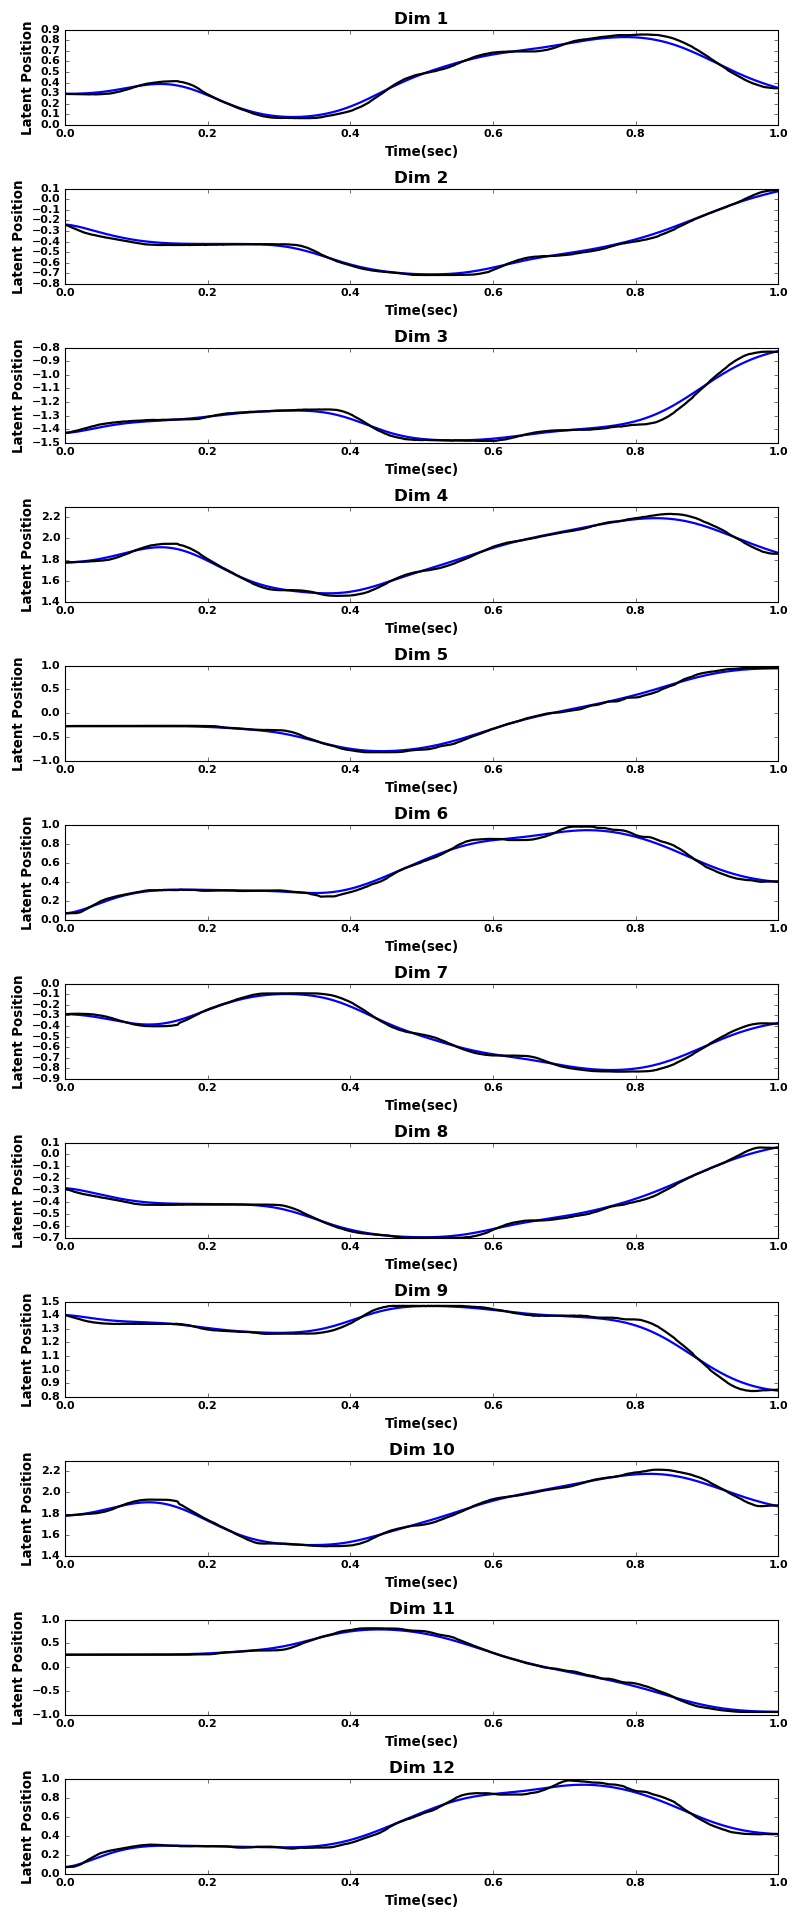

input,JA:Done


<IPython.core.display.Javascript object>


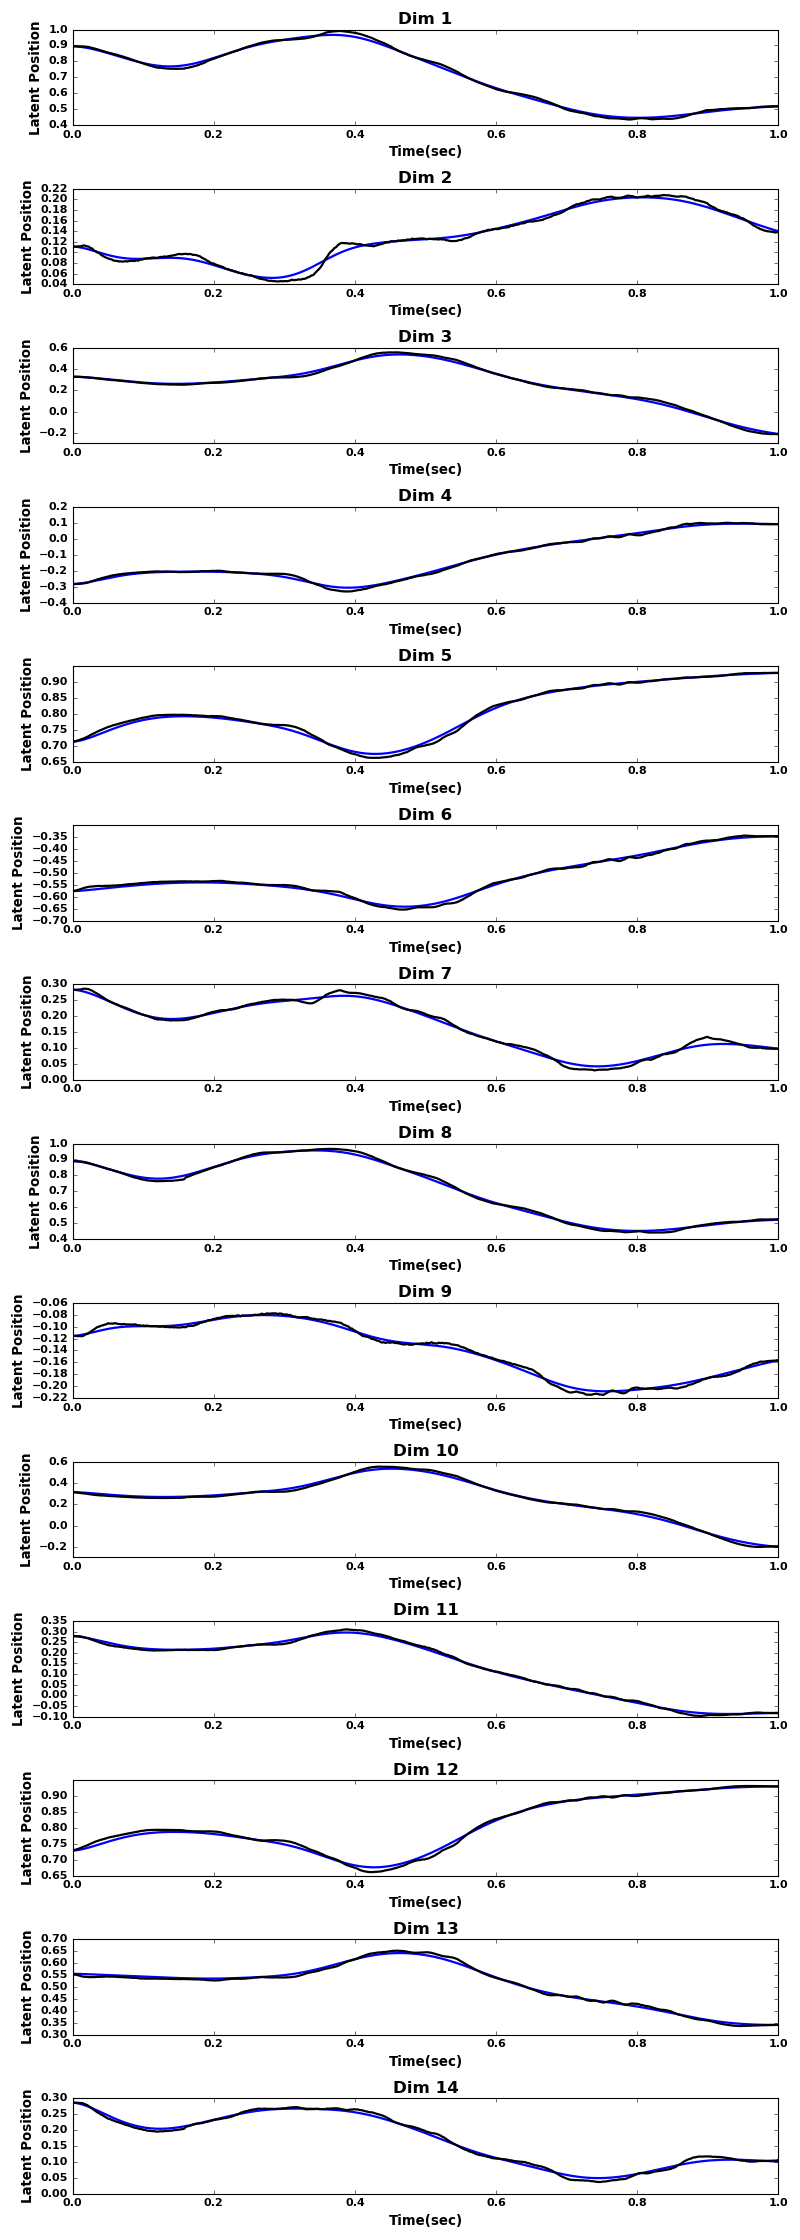

input,EE:Done


<IPython.core.display.Javascript object>


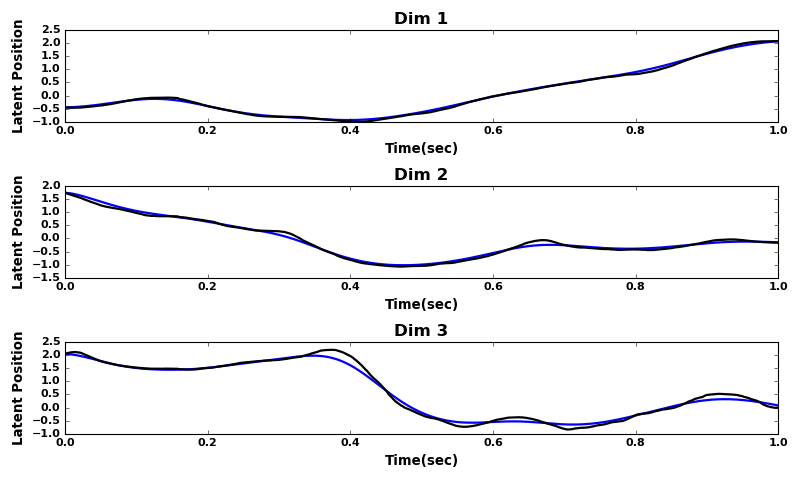

latent,JA:Done


<IPython.core.display.Javascript object>


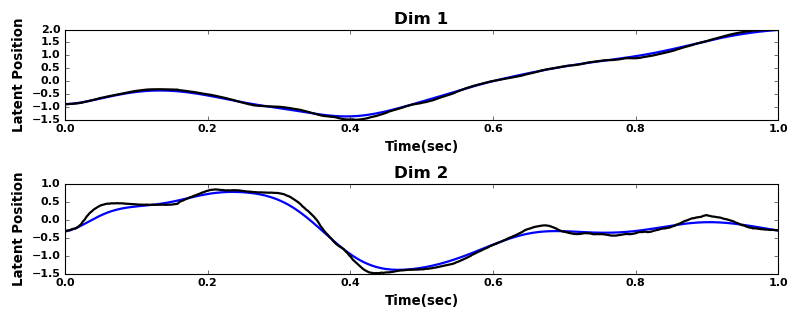

latent,EE:Done


In [13]:
# initialize parameters for training DMPs
nBFS = 100
source = 'Train'
keys = ['JA', 'EE']
modalities = ['input', 'latent']
dims = {'input':{'JA':np.asarray(range(7)+range(8,14)), 'EE':np.arange(15)},
        'latent':{'JA':np.arange(Data['latent']['JA']['Train'].shape[1]),
                  'EE':np.arange(Data['latent']['EE']['Train'].shape[1])}}

dmps = {}
dmpTrajs = {}
for modality in modalities:
    # setup the dicts with modality
    dmps[modality] = {}
    dmpTrajs[modality] = {}
    
    for key in keys:
        # get the relevant dimensions
        inputDim = dims[modality][key]
        data = Data[modality][key][source][:,inputDim]
        
        # initialize parameters to train DMP
        dt = 1.0/data.shape[0]
        nDims = inputDim.shape[0]-1
        
        # setup and train the DMP
        dmp = DMPs_discrete(dmps=nDims, bfs=nBFS, dt=dt)
        dmp.imitate_path(y_des=np.transpose(data[:,1:]))
        
        # generate a rollout from trained DMP
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(data[:,0])),dmpTraj),axis=1)
        
        # save the results to dicts
        dmps[modality][key] = dmp
        dmpTrajs[modality][key] = dmpTraj
        
        plotTraj2({'Raw':data,'DMP':dmpTraj}, colors={'Raw':'k','DMP':'b'})
        
        print '%s,%s:Done' % (modality,key)
        
pickle.dump(dmpTrajs, open('Results/DMP.p','wb'))

## Viapoints from Trajectories
---

In [ ]:
Data = pickle.load(open('Data/RLData.p','rb'))

<IPython.core.display.Javascript object>


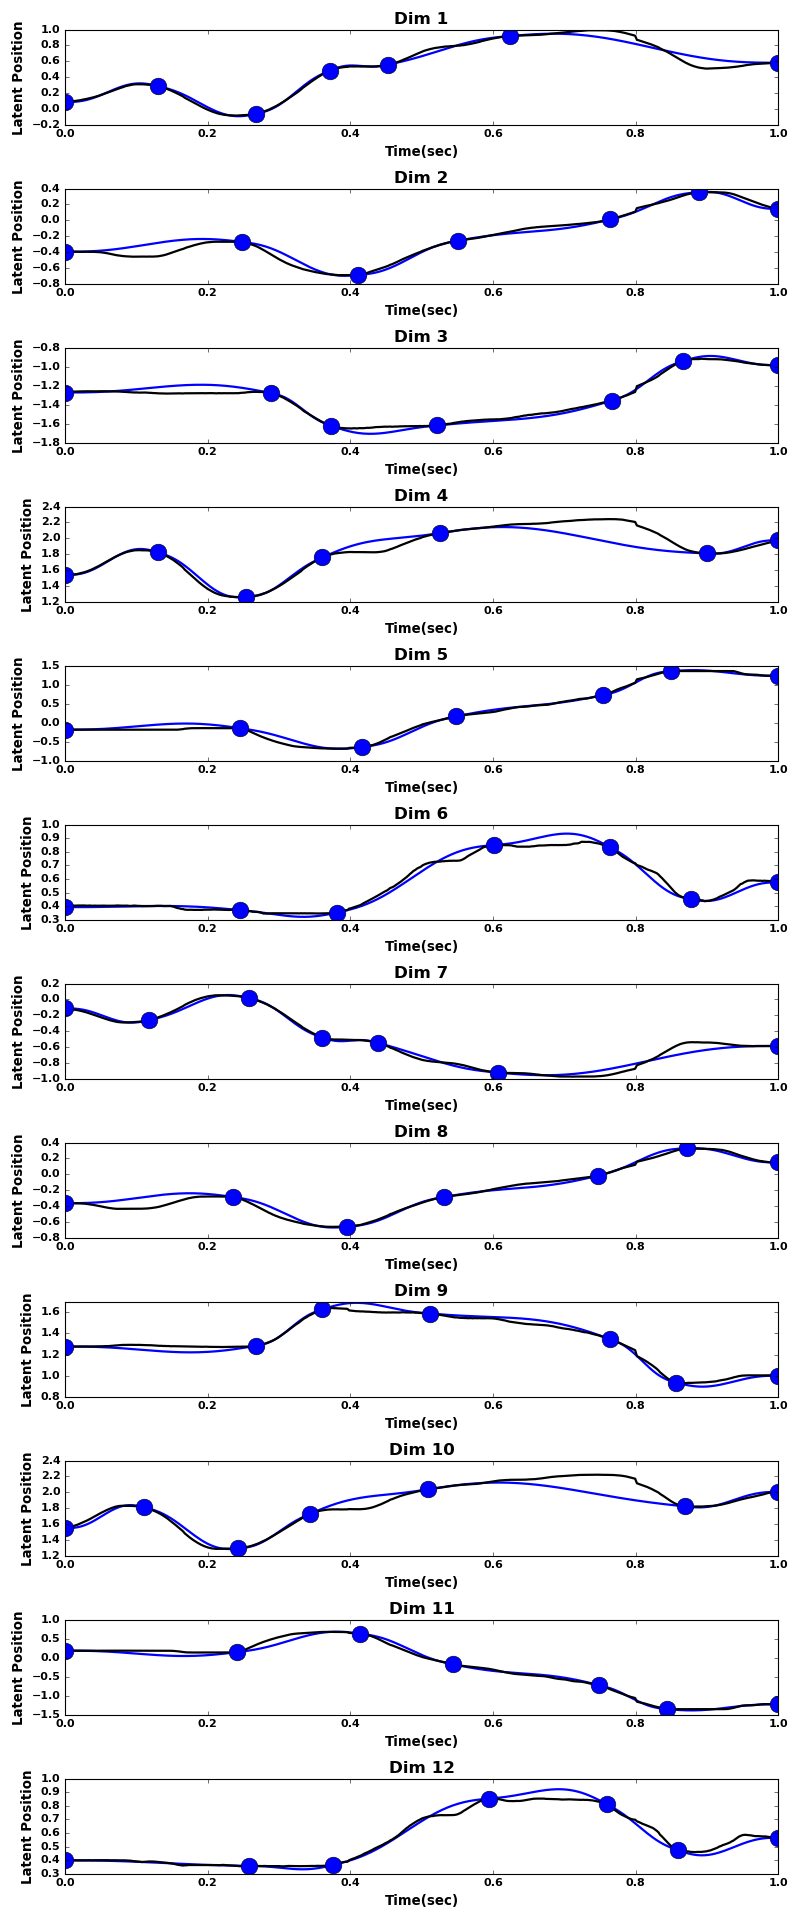

input,JA:Done


<IPython.core.display.Javascript object>


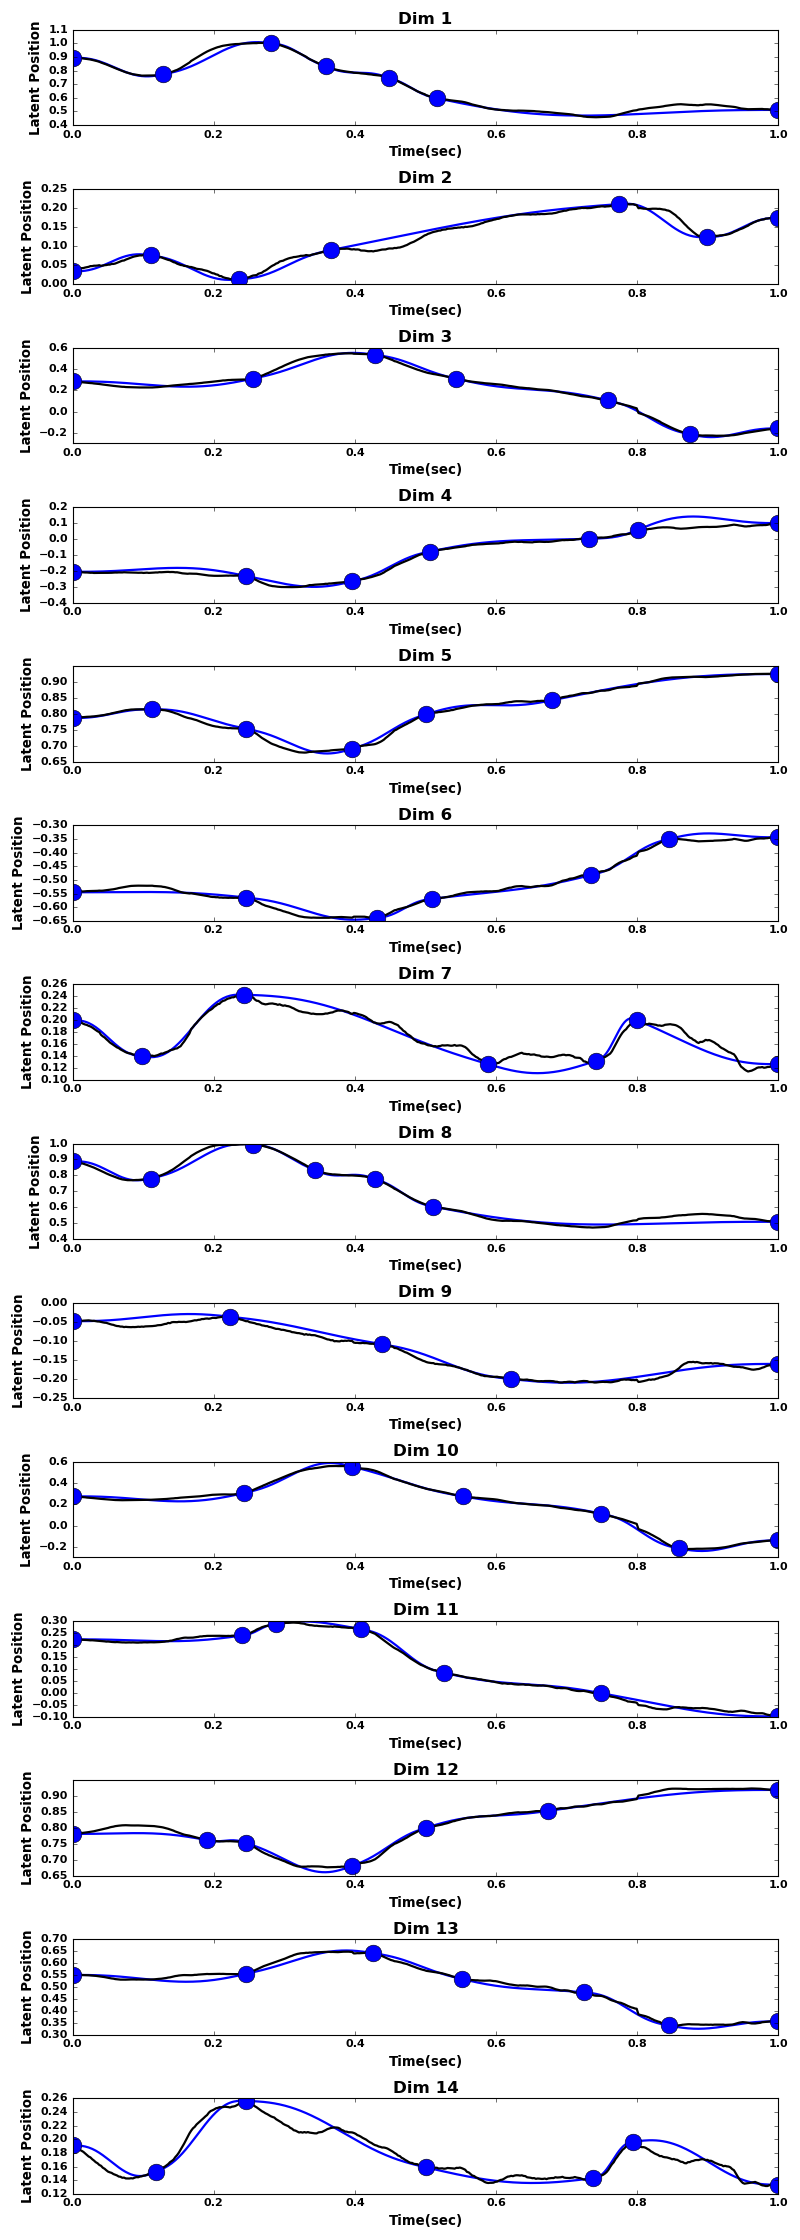

input,EE:Done


In [4]:
# initialize parameters for training DMPs
nVia = 7
source = 'Test'
modality = 'input'
keys = ['JA', 'EE']
dims = {'input':{'JA':np.asarray(range(7)+range(8,14)), 'EE':np.arange(15)}}

# objects and trajectories
viapointObjs = {}
viapointTrajs = {}
viapointParams = {}

for key in keys:
    # get the relevant dimensions
    inputDim = dims[modality][key]
    data = Data[modality][key][source][:,inputDim]
        
    # initialize viapoint extractor instance
    nDims = inputDim.shape[0]-1
    viapoint = ViaPoint(data, nDims=nDims, nViaPoints=nVia, errThresh=0.01)
    (viapointTraj, viapointParam) = viapoint.compute()

    # save the results to dicts
    viapointObjs[key] = viapoint
    viapointTrajs[key] = viapointTraj
    viapointParams[key] = viapointParam
    
    plotTraj2({'Raw':data,'VP':viapointTraj}, points = viapointParam, colors={'Raw':'k','VP':'b'})
    #viapoint.plot(viapointParams)
    print '%s,%s:Done' % (modality,key)
    
VP = {'Trajs':viapointTrajs, 'Params':viapointParams}
pickle.dump(VP, open('Results/VP.p','wb'))    

## Compile DMP, VP results
---

In [ ]:
# initialize parameters for training DMPs
source = 'Train'
modality = 'input'
keys = ['JA', 'EE']
dims = {'JA':np.asarray(range(7)+range(8,14)), 'EE':np.arange(15)}

for key in keys:
    # get the relevant dimensions
    inputDim = dims[key]
    dmpTraj = dmpTrajs[modality][key]
    viapointTraj = viapointTrajs[key]
    viapointParam = viapointParams[key]
    data = Data[modality][key][source][:,inputDim]

    plotTraj2({'Raw':data,'DMP':dmpTraj,'VP':viapointTraj}, points=viapointParam, colors={'Raw':'k','DMP':'b','VP':'g'})

## Cost Function for RL
---

In [18]:
# implement reward function such that trajectory passes through desired via-points
def rewardFunc(trajectory, params):
    # parameter initialization
    reward = 0.0
    vpFactor = 1e4
    nDims = len(params.keys())
    
    # loop over the dimensions
    for nD in range(nDims):
        # get vps and trajectory
        vps = params[nD][:,:2]
        traj = trajectory[:,[0,nD+1]]
        
        # loop over the viapoints
        nVia = params[nD].shape[0]
        for nV in range(nVia):
            idx = (np.abs(traj[:,0]-vps[nV,0])).argmin()
            reward += vpFactor*((traj[idx,1]-vps[nV,1])**2)
    
    # return reward for complete trajectory
    return reward

## Cross Entropy Method RL for Input JA Trajectory
---

In [22]:
# obtain desired DMP
dmp = dmps['input']['JA']
dmpTraj = dmpTrajs['input']['JA']

# obtain desired via-points
vpParam = viapointParams['JA']

# obtain starting point and goal point for new trajectory
nDims = len(vpParam.keys())

# initialize policy parameters mean
policyMean = dmp.w

# initialize policy variance
policyVar = (policyMean)**2

# do monte-carlo rollouts and evaluate rewards
nKeep = 5
nRollouts = 50
nBFS = policyMean.shape[1]
nSamples = dmpTraj.shape[0]

# save the trajectories
colors = {}
epsRewards = {}
trajectories = {}

# number of iters to run loop
nIters = 100

In [23]:
for it in range(nIters):
    trajs = {}
    rollouts = {}
    
    for nR in range(nRollouts):
        # parameter rollout
        rollout = policyMean.copy()
    
        # generate the rollout parameters 
        for d in range(nDims):
            mean = policyMean[d,:]
            cov = (policyVar[d,:])*np.eye(nBFS)
            rollout[d,:] = np.random.multivariate_normal(mean,cov)
        
        # generate trajectory from parameters
        rollouts[nR] = rollout
        dmp.w = rollouts[nR]
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['JA'][:,0])),dmpTraj),axis=1)
    
        trajs[nR] = dmpTraj

    # compute rewards for all the trajectories
    rewards = np.zeros(nRollouts)
    for key in trajs.keys():
        rewards[key] = rewardFunc(trajs[key],vpParam)
    
    # sort the rewards and keep the top few trials
    trajInds = rewards.argsort()[:nKeep]

    # obtain the best trajectories and policy parameters
    bestPolicies = np.zeros((nKeep,nDims,nBFS))
    for ind,trajInd in enumerate(trajInds):
        bestPolicies[ind,:,:] = rollouts[trajInd]

    # compute new means and variances for policy parameters
    policyMean = bestPolicies.mean(axis=0)
    policyVar = bestPolicies.var(axis=0)

    # generate trajectory from dmp
    dmp.w = policyMean
    dmpTraj,_,_ = dmp.rollout()
    dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['JA'][:,0])),dmpTraj),axis=1)
    
    trajectories[it] = dmpTraj
    colors[it] = np.random.rand(3,)
    epsRewards[it] = rewardFunc(trajectories[it],vpParam)
    
    print it, epsRewards[it]

<IPython.core.display.Javascript object>


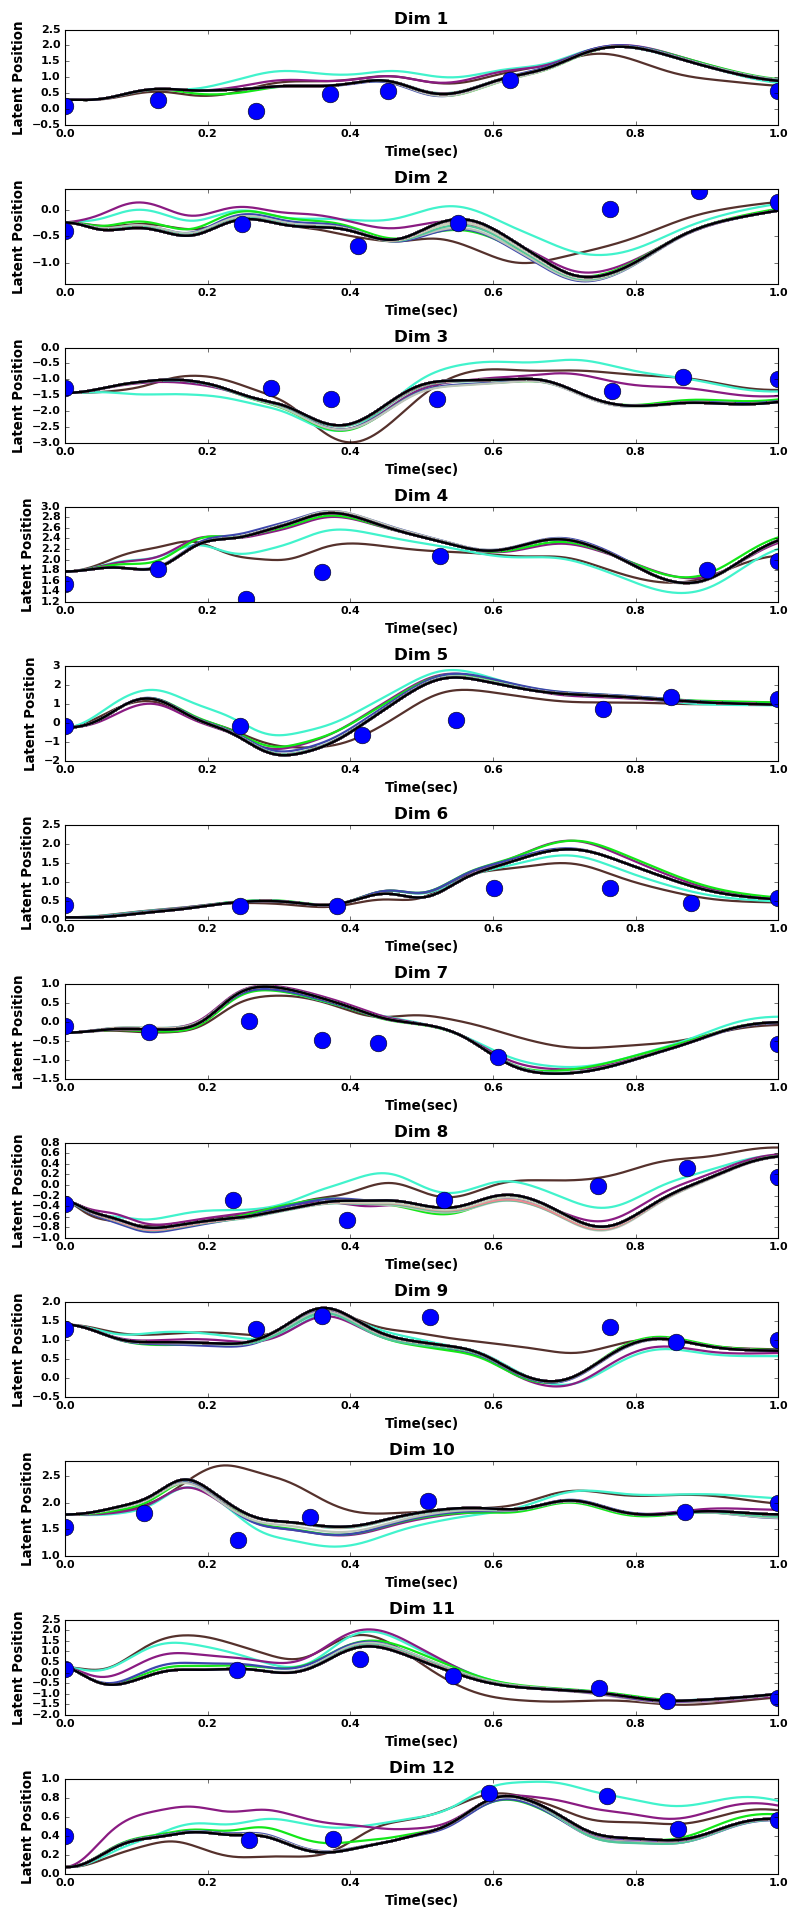

In [21]:
colors['Org'] = 'k'
trajectories['Org'] = dmpTraj

plotTraj2(trajectories, points=vpParam, colors=colors)